开始处理电池数据...
找到 6 个数据文件
处理文件: 2025-09-02.xlsx
  检测到 1 个充电周期
处理文件: 2025-09-16.xlsx
  检测到 1 个充电周期
    周期 1: SOH = 84.15%
处理文件: 2025-09-28.xlsx
  检测到 1 个充电周期
    周期 1: SOH = 85.83%
处理文件: 2025-10-01.xlsx
  检测到 1 个充电周期
处理文件: 2025-10-15.xlsx
  检测到 1 个充电周期
    周期 1: SOH = 95.21%
处理文件: 2025-10-30.xlsx
  检测到 1 个充电周期
    周期 1: SOH = 88.24%
月份 2025-09: 2 个有效计算结果
月份 2025-10: 2 个有效计算结果
生成SOH趋势图...


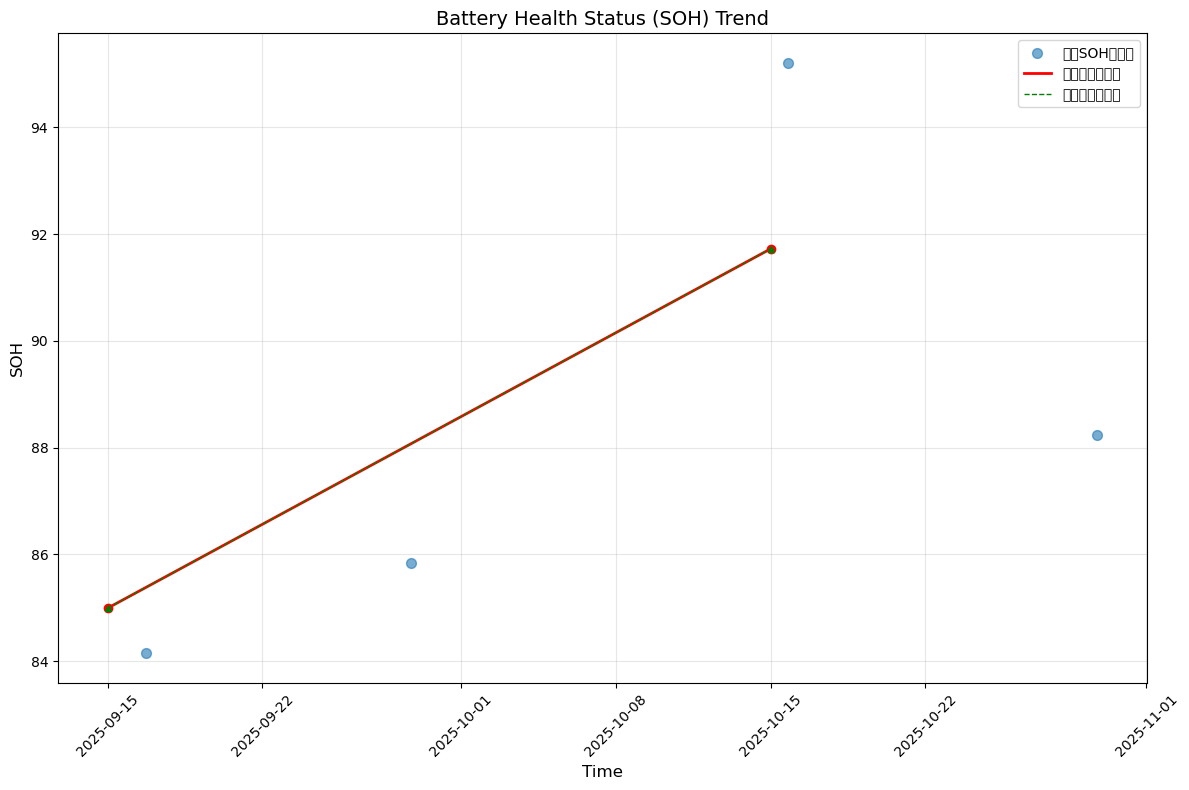

生成详细报告...
报告已保存到: soh_detailed_report.csv

=== 处理完成 ===
处理月份数: 2
总计算次数: 4
初始SOH: 84.99%
最终SOH: 91.73%
SOH衰减: -6.74%


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import glob

class BatterySOHCalculator:
    def __init__(self, rated_capacity=352):
        """
        初始化电池SOH计算器
        
        Args:
            rated_capacity: 电池额定容量 (Ah)
        """
        self.rated_capacity = rated_capacity
        self.results = {}
    
    def load_data(self, file_path):
        """
        加载数据文件
        """
        try:
            # 读取Excel文件
            df = pd.read_excel(file_path)
            
            # 确保时间列为datetime类型
            if '数据时间' in df.columns:
                df['数据时间'] = pd.to_datetime(df['数据时间'])
            
            # 重命名列以便统一处理
            column_mapping = {
                '数据时间': 'timestamp',
                '充放电电流': 'current',
                'SOC': 'soc',
                '电池系统额定容量': 'rated_capacity'
            }
            
            df = df.rename(columns=column_mapping)
            
            # 按时间排序
            df = df.sort_values('timestamp')
            
            return df
            
        except Exception as e:
            print(f"数据加载错误: {e}")
            return None
    
    def detect_charging_cycles(self, df, min_soc_change=5, min_duration_minutes=10):
        """
        检测充电周期
        
        Args:
            df: 数据DataFrame
            min_soc_change: 最小SOC变化量 (%)
            min_duration_minutes: 最小充电时长 (分钟)
        """
        charging_cycles = []
        
        if df is None or len(df) < 2:
            return charging_cycles
            
        # 获取数据列
        soc = df['soc'].values
        current = df['current'].values
        timestamp = df['timestamp'].values
        

        # 找到SOC最小值点
        min_soc_idx = np.argmin(soc)
        min_soc = soc[min_soc_idx]

 
        start_idx = min_soc_idx
        start_soc = min_soc
        start_time = timestamp[min_soc_idx]
        
        # 从最小值点开始，找到SOC最大值点
        max_soc_idx = np.argmax(soc[min_soc_idx:]) + min_soc_idx
        max_soc = soc[max_soc_idx]
        max_time = timestamp[max_soc_idx]
        
        # 计算持续时间
        try:
            if hasattr(max_time, 'timestamp') and hasattr(start_time, 'timestamp'):
                duration = (max_time - start_time).total_seconds() / 60
            else:
                duration = (pd.Timestamp(max_time) - pd.Timestamp(start_time)).total_seconds() / 60
                
            soc_change = max_soc - start_soc
            
            # 检查是否满足最小条件
            if (soc_change >= min_soc_change and 
                duration >= min_duration_minutes):
                
                charging_cycles.append({
                    'start_idx': start_idx,
                    'end_idx': max_soc_idx,
                    'start_soc': start_soc,
                    'end_soc': max_soc,
                    'start_time': start_time,
                    'end_time': max_time,
                    'duration_minutes': duration,
                    'soc_change': soc_change
                })
        except Exception as e:
            print(f"时间计算错误: {e}")
    
        return charging_cycles

    
    def calculate_capacity_from_cycle(self, df, cycle):
        """
        根据充电周期计算电池容量
        """
        try:
            # 提取充电周期数据
            cycle_data = df.iloc[cycle['start_idx']:cycle['end_idx']+1].copy()
            
            if len(cycle_data) < 2:
                return None
            
            # 计算时间间隔 (小时) - 修复：使用正确的timedelta处理
            # 方法1: 转换为pandas Timestamp再计算
            cycle_data['timestamp_pd'] = pd.to_datetime(cycle_data['timestamp'])
            cycle_data['time_diff'] = cycle_data['timestamp_pd'].diff().dt.total_seconds().fillna(0) / 3600
            
            # 计算充电电量 (Ah) - 取电流绝对值并积分
            cycle_data['charge_ah'] = abs(cycle_data['current']) * cycle_data['time_diff']
            total_charge_ah = cycle_data['charge_ah'].sum()
            
            # 计算当前最大容量
            soc_change = cycle['end_soc'] - cycle['start_soc']
            if soc_change > 0:
                current_capacity = (total_charge_ah / soc_change) * 100
                soh = (current_capacity / self.rated_capacity) * 100
                
                return {
                    'current_capacity': current_capacity,
                    'soh': soh,
                    'total_charge_ah': total_charge_ah,
                    'soc_change': soc_change,
                    'start_time': cycle['start_time'],
                    'end_time': cycle['end_time'],
                    'data_points': len(cycle_data)
                }
            else:
                return None
                
        except Exception as e:
            print(f"容量计算错误: {e}")
            return None
    
    def process_single_file(self, file_path):
        """
        处理单个文件，计算SOH
        """
        print(f"处理文件: {os.path.basename(file_path)}")
        
        # 加载数据
        df = self.load_data(file_path)
        if df is None or df.empty:
            print(f"  文件数据为空或加载失败，跳过")
            return None
        
        # 提取日期信息
        file_date = df['timestamp'].iloc[0]
        
        # 修复：正确处理numpy datetime64
        if isinstance(file_date, np.datetime64):
            file_date = pd.Timestamp(file_date)
        
        year_month = file_date.strftime('%Y-%m')
        
        # 检测充电周期
        charging_cycles = self.detect_charging_cycles(df)
        print(f"  检测到 {len(charging_cycles)} 个充电周期")
        
        # 计算每个充电周期的SOH
        file_results = []
        for i, cycle in enumerate(charging_cycles):
            result = self.calculate_capacity_from_cycle(df, cycle)
            if result and 50 < result['soh'] <= 120:  # 过滤异常值
                file_results.append(result)
                print(f"    周期 {i+1}: SOH = {result['soh']:.2f}%")
        
        return {
            'year_month': year_month,
            'file_date': file_date,
            'results': file_results
        }
    
    def process_monthly_data(self, data_folder, years=3):
        """
        处理3年的月度数据
        
        Args:
            data_folder: 数据文件夹路径
            years: 处理多少年的数据
        """
        monthly_soh = {}
        
        # 获取所有数据文件
        data_files = glob.glob(os.path.join(data_folder, "*.xlsx")) + glob.glob(os.path.join(data_folder, "*.xls"))
        
        if not data_files:
            print(f"在文件夹 {data_folder} 中没有找到Excel文件")
            return monthly_soh
        
        print(f"找到 {len(data_files)} 个数据文件")
        
        # 处理每个文件
        for file_path in data_files:
            file_result = self.process_single_file(file_path)
            
            if file_result and file_result['results']:
                year_month = file_result['year_month']
                if year_month not in monthly_soh:
                    monthly_soh[year_month] = []
                
                monthly_soh[year_month].extend(file_result['results'])
        
        # 打印汇总信息
        for month in sorted(monthly_soh.keys()):
            print(f"月份 {month}: {len(monthly_soh[month])} 个有效计算结果")
        
        return monthly_soh
    
    def plot_soh_trend(self, monthly_soh, output_path='soh_trend.png'):
        """
        绘制SOH变化趋势图
        """
        if not monthly_soh:
            print("没有数据可绘制")
            return None, None
            
        plt.figure(figsize=(12, 8))
        
        # 准备绘图数据
        all_months = sorted(monthly_soh.keys())
        all_soh_values = []
        all_dates = []
        
        for month in all_months:
            monthly_data = monthly_soh[month]
            for result in monthly_data:
                all_soh_values.append(result['soh'])
                
                # 修复：正确处理日期类型
                date = result['start_time']
                if isinstance(date, np.datetime64):
                    date = pd.Timestamp(date)
                all_dates.append(date)
        
        # 绘制散点图
        plt.scatter(all_dates, all_soh_values, alpha=0.6, s=50, label='每日SOH计算值')
        
        # 计算并绘制月度中位数趋势线
        monthly_medians = {}
        monthly_means = {}
        for month in all_months:
            monthly_data = monthly_soh[month]
            soh_values = [r['soh'] for r in monthly_data]
            monthly_medians[month] = np.median(soh_values)
            monthly_means[month] = np.mean(soh_values)
        
        median_dates = [datetime.strptime(month + '-15', '%Y-%m-%d') for month in all_months]
        median_soh = [monthly_medians[month] for month in all_months]
        mean_soh = [monthly_means[month] for month in all_months]
        
        plt.plot(median_dates, median_soh, 'r-', linewidth=2, label='月度中位数趋势')
        plt.plot(median_dates, median_soh, 'ro', markersize=6)
        
        plt.plot(median_dates, mean_soh, 'g--', linewidth=1, label='月度平均值趋势')
        plt.plot(median_dates, mean_soh, 'g^', markersize=4)
        
        # 图表美化
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('SOH', fontsize=12)
        plt.title('Battery Health Status (SOH) Trend', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # 保存图表
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return median_dates, median_soh
    
    def generate_report(self, monthly_soh, output_file='soh_report.csv'):
        """
        生成详细的SOH报告
        """
        if not monthly_soh:
            print("没有数据生成报告")
            return None
            
        report_data = []
        
        for month, monthly_data in monthly_soh.items():
            for result in monthly_data:
                # 修复：正确处理日期格式化
                start_time = result['start_time']
                if isinstance(start_time, np.datetime64):
                    start_time = pd.Timestamp(start_time)
                
                report_data.append({
                    '年月': month,
                    '计算日期': start_time.strftime('%Y-%m-%d'),
                    'SOH(%)': f"{result['soh']:.2f}",
                    '当前容量(Ah)': f"{result['current_capacity']:.2f}",
                    '充电电量(Ah)': f"{result['total_charge_ah']:.2f}",
                    'SOC变化(%)': f"{result['soc_change']:.2f}",
                    '数据点数': result['data_points']
                })
        
        report_df = pd.DataFrame(report_data)
        report_df.to_csv(output_file, index=False, encoding='utf-8-sig')
        
        print(f"报告已保存到: {output_file}")
        return report_df

# 使用示例
def main():
    # 初始化计算器
    calculator = BatterySOHCalculator(rated_capacity=352)
    
    # 假设数据文件存放在 'battery_data' 文件夹中
    data_folder = 'battery_data'
    
    # 如果文件夹不存在，创建示例数据
    if not os.path.exists(data_folder):
        print(f"数据文件夹 {data_folder} 不存在，请确保数据文件已放置在该文件夹中")
        print("数据文件应该是Excel格式(.xlsx或.xls)")
        return
    
    # 处理数据
    print("开始处理电池数据...")
    monthly_soh = calculator.process_monthly_data(data_folder, years=3)
    
    if not monthly_soh:
        print("没有找到有效的数据或充电周期")
        return
    
    # 绘制趋势图
    print("生成SOH趋势图...")
    median_dates, median_soh = calculator.plot_soh_trend(monthly_soh, 'soh_trend.png')
    
    # 生成详细报告
    print("生成详细报告...")
    report_df = calculator.generate_report(monthly_soh, 'soh_detailed_report.csv')
    
    # 打印汇总信息
    print(f"\n=== 处理完成 ===")
    print(f"处理月份数: {len(monthly_soh)}")
    total_calculations = sum(len(data) for data in monthly_soh.values())
    print(f"总计算次数: {total_calculations}")
    
    if median_soh:
        print(f"初始SOH: {median_soh[0]:.2f}%")
        print(f"最终SOH: {median_soh[-1]:.2f}%")
        print(f"SOH衰减: {median_soh[0] - median_soh[-1]:.2f}%")

# 直接测试单个文件的函数
def test_single_file(file_path):
    """
    测试单个文件的SOH计算
    """
    calculator = BatterySOHCalculator(rated_capacity=352)
    result = calculator.process_single_file(file_path)
    
    if result and result['results']:
        soh_values = [r['soh'] for r in result['results']]
        avg_soh = np.mean(soh_values)
        print(f"文件平均SOH: {avg_soh:.2f}%")
        return avg_soh
    else:
        print("无法计算SOH")
        return None

if __name__ == "__main__":
    # 运行主程序
    main()
    
    # # 如果需要测试单个文件，取消下面的注释并指定文件路径
    # test_single_file("path/to/your/file.xlsx")

In [60]:
df

,数据时间,动力总成控制器输入电压,动力总成控制器输入电流,驱动电机温度,DCDC输出电压,DCDC输出电流,DCDC输入电压,电池总电压,充放电电流,SOC,电池系统额定容量,电池系统额定电压
0,2025-10-29 21:19:07,1,3,38,25.1,0.0,0,499.4,-13.3,99.2,352,460.8
1,2025-10-29 21:18:57,1,3,38,25.1,0.0,0,498.9,-13.2,99.2,352,460.8
2,2025-10-29 21:18:47,1,3,38,25.1,0.0,0,498.5,-13.2,99.2,352,460.8
3,2025-10-29 21:18:37,0,3,38,25.1,0.0,0,498.1,-13.3,99.2,352,460.8
4,2025-10-29 21:18:27,1,3,38,25.1,0.0,0,497.9,-13.2,99.2,352,460.8
...,...,...,...,...,...,...,...,...,...,...,...,...
1496,2025-10-29 16:00:42,470,6,74,27.3,29.6,475,474.2,3.6,88.4,352,460.8
1497,2025-10-29 16:00:32,465,137,73,27.3,29.0,469,469.8,131.7,88.4,352,460.8
1498,2025-10-29 16:00:22,466,116,76,27.3,30.3,471,470.9,115.1,88.4,352,460.8
1499,2025-10-29 16:00:12,471,40,71,27.3,35.1,475,475.3,32.9,88.8,352,460.8
